In [5]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [6]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [7]:
ab = '../'+expand(config['data']['ab'], species='human')[0]
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
read_annot = '../'+expand(config['data']['read_annot'], species='human')[0]
t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_lib_meta = '../'+expand(config['data']['meta'], species='mouse')[0]


## Long read gene detection by biotype

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2038: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2037: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Applying gene type and novelty subset
Number of genes reported: 39681
Detected 39681 / 52274 (75.9%) annotated polyA genes
protein_coding
93.69121472883731

lncRNA
60.36173089925625

pseudogene
29.797771357820885



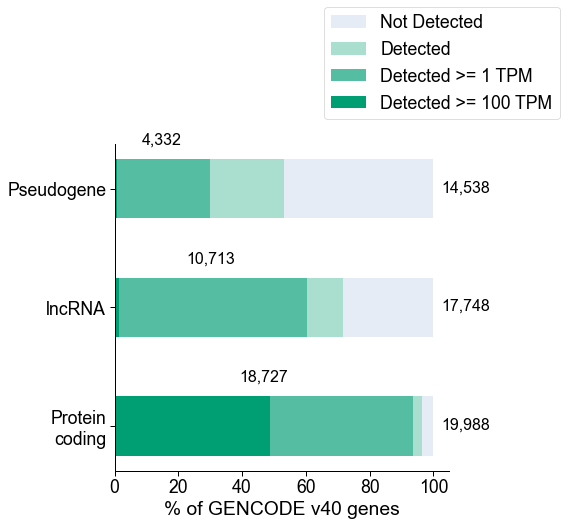

In [9]:
df = pd.read_csv(ab, sep='\t')
plot_gene_det_by_biotype_tpm(df,
                             how='gene',
                             ver=ver)

## Gene detection by sample

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2058: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2057: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 1 tpm: 292060
Applying gene type and novelty subset
Number of genes reported: 33772
Found 50 total samples


<Figure size 432x432 with 0 Axes>

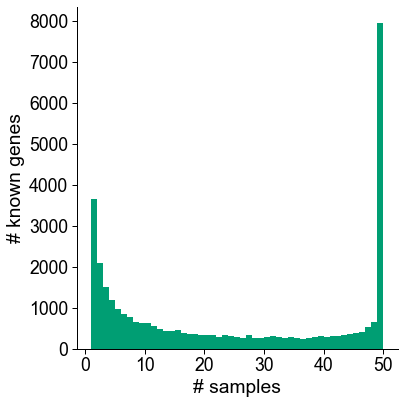

In [6]:
df = pd.read_csv(ab, sep='\t')
df = plot_biosamp_det(df,
                 how='gene',
                 min_tpm=min_tpm,
                 gene_subset=gene_subset,
                 sample=None,
                 groupby=obs_col,
                 nov=['Known'],
                 opref='figures/human')

In [7]:
specific_thresh = 8
ubiq_thresh = 30

n_iso = len(df.index)
n_specific = len(df.loc[df.n_samples <= specific_thresh].index)
n_ubiq = len(df.loc[df.n_samples >= ubiq_thresh].index)

print('{} / {} ({:.1f}%) transcripts are expressed in <= {} samples'.format(n_specific, n_iso, (n_specific/n_iso)*100, specific_thresh))
print('{} / {} ({:.1f}%) transcripts are expressed in >= {} samples'.format(n_ubiq, n_iso, (n_ubiq/n_iso)*100, ubiq_thresh))

specific_thresh = 10
ubiq_thresh = 90

n_samples = len(df.columns)
df['perc'] = (df.n_samples/n_samples)*100

n_iso = len(df.index)
n_specific = len(df.loc[df.perc < specific_thresh].index)
n_ubiq = len(df.loc[df.perc > ubiq_thresh].index)

print('{} / {} ({:.1f}%) transcripts are expressed in <= {}% samples'.format(n_specific, n_iso, (n_specific/n_iso)*100, specific_thresh))
print('{} / {} ({:.1f}%) transcripts are expressed in >= {}% samples'.format(n_ubiq, n_iso, (n_ubiq/n_iso)*100, ubiq_thresh))


11677 / 33772 (34.6%) transcripts are expressed in <= 8 samples
14162 / 33772 (41.9%) transcripts are expressed in >= 30 samples
9396 / 33772 (27.8%) transcripts are expressed in <= 10% samples
9537 / 33772 (28.2%) transcripts are expressed in >= 90% samples


## Box plots for number of libraries, samples, and tissues / cell types

In [23]:
h_meta = pd.read_csv(lib_meta, sep='\t')
m_meta = pd.read_csv(m_lib_meta, sep='\t')

In [24]:
h_meta['species'] = 'Human'
m_meta['species'] = 'Mouse'
keep_cols = ['dataset', 'sample', 'general_tissue_cell_type', 'tissue_or_cell_line', 'species']
df = pd.concat([h_meta, m_meta], axis=0)[keep_cols]

In [25]:
# gb species and tissue_or_cell_line and count libraries
temp = df.groupby(['tissue_or_cell_line', 'species']).count().reset_index()
temp = temp[['tissue_or_cell_line', 'species', 'dataset']]
temp.rename({'dataset': 'n_libraries'}, axis=1, inplace=True)

# gb species and tissue_or_cell_line and count samples
temp2 = df.groupby(['tissue_or_cell_line', 'species']).nunique().reset_index()
temp2 = temp2[['tissue_or_cell_line', 'species', 'sample']]
temp2.rename({'sample': 'n_samples'}, axis=1, inplace=True)
temp = temp.merge(temp2, on=['species', 'tissue_or_cell_line'])

# gb species and tissue_or_cell_line and count general tissue / cell line
temp3 = df.groupby(['tissue_or_cell_line', 'species']).nunique().reset_index()
temp3 = temp3[['tissue_or_cell_line', 'species', 'general_tissue_cell_type']]
temp3.rename({'general_tissue_cell_type': 'n_general'}, axis=1, inplace=True)
temp = temp.merge(temp3, on=['species', 'tissue_or_cell_line'])

In [26]:
def make_summary_box_plot(temp, y, ylabel, ofile):
    sns.set_context('paper', font_scale=2)
    plt.figure(figsize=(3,2.25))
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42

    c_dict, order = get_tissue_cell_line_colors()    
    ax = sns.barplot(data=temp, x='species', y=y,
                hue='tissue_or_cell_line',
                palette=c_dict, saturation=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    xlabel = ''
    ylabel = ylabel

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax.get_legend().remove()
    _ = ax.set(xlabel=xlabel, ylabel=ylabel)

    def add_perc_2(ax):
        ylim = ax.get_ylim()[1]
        n_cats = len(ax.patches)
        for p in ax.patches:
            label = '{:.0f}'.format(p.get_height())
            x = p.get_x() + p.get_width() / 2
            y = p.get_y() + p.get_height() + ylim*0.01
            ax.annotate(label, (x, y), size=16, horizontalalignment='center')


    add_perc_2(ax)
    plt.savefig(ofile, dpi=500, layout='tight', bbox_inches="tight")

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6


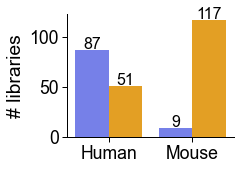

In [27]:
make_summary_box_plot(temp, 'n_libraries', '# libraries', 'figures/library_box_plot.pdf')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6


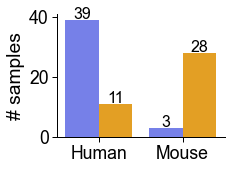

In [28]:
make_summary_box_plot(temp, 'n_samples', '# samples', 'figures/sample_box_plot.pdf')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6


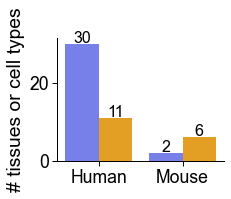

In [29]:
make_summary_box_plot(temp, 'n_general', '# tissues or cell types', 'figures/general_box_plot.pdf')

## Number of libraries vs. number of tissues / cell lines

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6


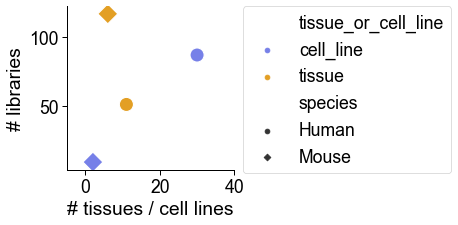

In [30]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(3,3))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

style_dict = {'Human': 'o', 'Mouse': 'D'}
c_dict, order = get_tissue_cell_line_colors()
ax = sns.scatterplot(data=temp, x='n_general', y='n_libraries',
            hue='tissue_or_cell_line', style='species', markers=style_dict,
            palette=c_dict, alpha=1, s=200)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xlabel = '# tissues / cell lines'
ylabel = '# libraries'
xlim = (-5, 40)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
_ = ax.set(xlabel=xlabel, ylabel=ylabel, xlim=xlim)

fname = 'figures/data_summary_libraries_v_tissue_cell_line.pdf'
plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")

## Human sample color legend

Read in graph from ../data/human/swan_graph.p


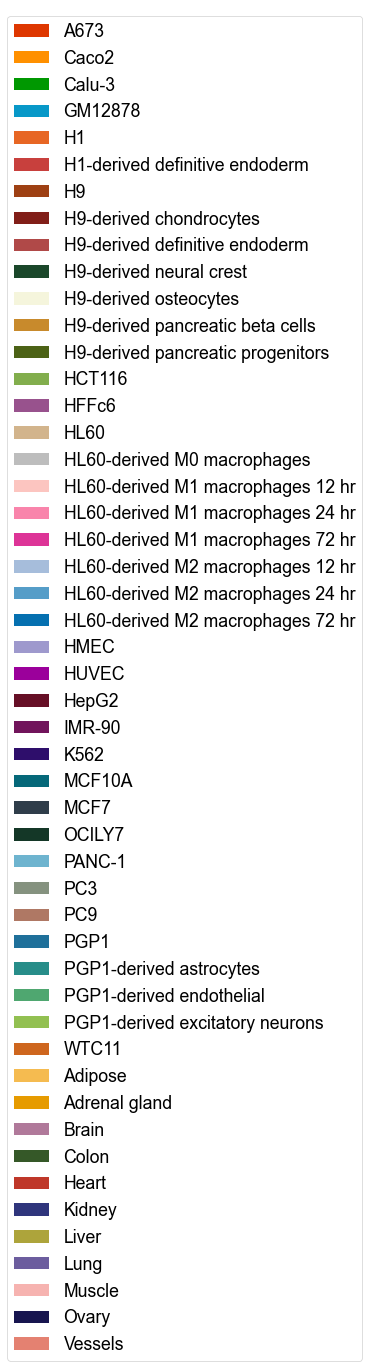

In [4]:
plot_human_sample_legend(swan_file,
                   'figures/human_sample_color_legend.pdf')

## Human LR-RNA-seq read lengths

<Figure size 108x144 with 0 Axes>

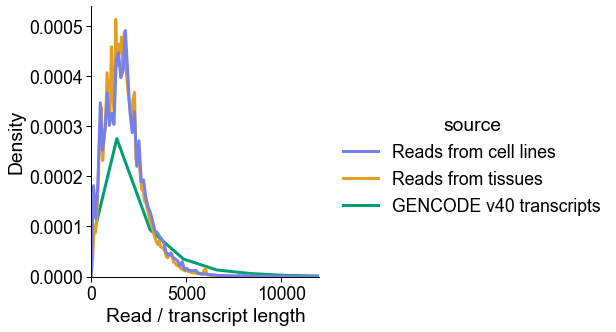

In [5]:
df = pd.read_csv(read_annot, usecols=[1,8], sep='\t') 
plot_cell_line_tissue_read_len_v_ref(df, 
                                     'polya',
                                     t_metadata,
                                     12000,
                                     'figures/tissue_cell_line_ref_read_len.pdf')

<Figure size 108x144 with 0 Axes>

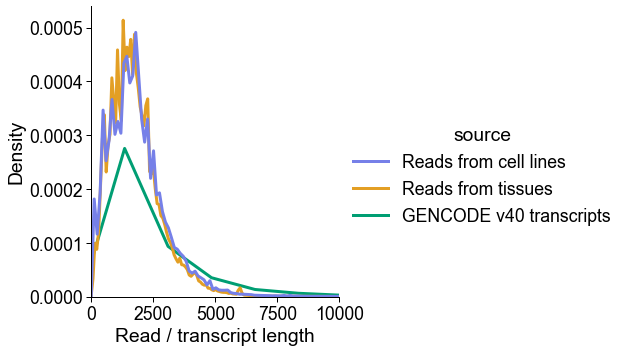

In [4]:
df = pd.read_csv(read_annot, usecols=[1,8], sep='\t') 
plot_cell_line_tissue_read_len_v_ref(df, 
                                     gene_subset,
                                     t_metadata,
                                     10000,
                                     'figures/tissue_cell_line_ref_read_len.pdf')

## Transcript detection and length for MANE transcripts

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2038: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2037: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 10 tpm: 39652
Applying gene type and novelty subset
Number of genes reported: 20655
Found 138 total libraries
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples


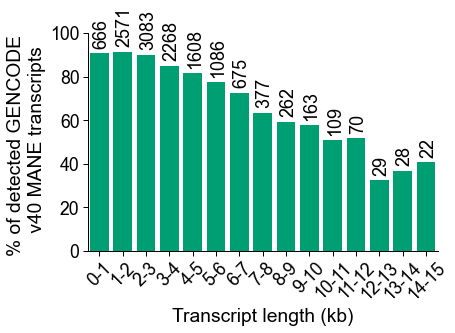

In [4]:
df = plot_perc_mane_det_by_len(ab,
                          filt_ab,
                          t_metadata,
                          min_gene_tpm=10,
                          min_tpm=1,
                          obs_col=obs_col,
                          max_t_len=15000,
                          figsize=(6,4),
                          fname='figures/mane_det_by_len.pdf')

## What % of genes of different biotypes do we detect at least one transcript for? 

In [5]:
df,_,_ = get_gtf_info(how='iso',
                      ver=ver,
                      subset=gene_subset)

In [6]:
# l = 7000
l = 12000
n = len(df.index)
n_num = len(df.loc[df.t_len<l].index)
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) of v40 polya transcripts are <{l}bp long')

99.65% (234736/235562) of v40 polya transcripts are <12000bp long


In [8]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
               how='iso',
               min_tpm=min_tpm,
               gene_subset=gene_subset)
df = df.reset_index()
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df = df[['gid']].drop_duplicates()

gene_df, _, counts = get_gtf_info(how='gene', ver=ver)
gene_df['gid_stable'] = cerberus.get_stable_gid(gene_df, 'gid')
df = df.merge(gene_df, how='left',left_on='gid', right_on='gid_stable')
df = df[['gid_stable', 'biotype_category']]

df = df.groupby('biotype_category').count().reset_index()
df.rename({'gid_stable': 'n_genes'}, axis=1, inplace=True)

df = df.merge(counts, on='biotype_category')
df['perc'] = (df.n_genes/df.gencode_counts)*100
df

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2038: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2037: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806


,biotype_category,n_genes,gencode_counts,perc
0,lncRNA,5483,17748,30.893622
1,protein_coding,17523,19988,87.667601
2,pseudogene,3775,14538,25.966433


## GO on undetected genes

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2038: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2037: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 1 tpm: 292060
Applying gene type and novelty subset
Number of genes reported: 18727
61544
19988
1261


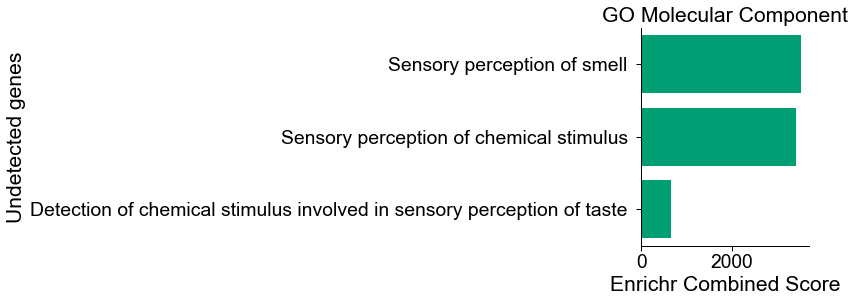

In [4]:
human_undet_gene_go(ab,
                    go_gene_subset,
                    min_tpm,
                    'figures/undet_pc_go.pdf')